In [1]:
# Load pandas dataframe with reviews
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 300

from iclr_analysis import prep_open_review_data, get_perf_metrics

# Confusion Matrix

In [2]:
# Load the data
ore_reviews = prep_open_review_data()

path_fname = "llm_reviews/gpt-4o-2024-05-13_temp_0_1_fewshot_1_reflect_5_ensemble_5_pages_all.csv"
gpt_4o = pd.read_csv(path_fname, index_col=0)
ids = gpt_4o.index

path_fname = "llm_reviews/gpt-4o-mini-2024-07-18_temp_0_1_fewshot_1_reflect_5_ensemble_5_pages_all.csv"
gpt_4o_mini = pd.read_csv(path_fname, index_col=0)

path_fname = "llm_reviews/gpt-4o-2024-05-13_temp_0_1_reflect_5_ensemble_5_pages_all.csv"
gpt_4o_no_fs = pd.read_csv(path_fname, index_col=0)

path_fname = "llm_reviews/gpt-4o-2024-05-13_temp_0_1_reflect_5_pages_all.csv"
gpt_4o_no_fs_no_ens = pd.read_csv(path_fname, index_col=0)

path_fname = "llm_reviews/gpt-4o-2024-05-13_temp_0_1_pages_all.csv"
gpt_4o_no_fs_no_ens_no_reflect = pd.read_csv(path_fname, index_col=0)

path_fname = (
    "llm_reviews/claude-3-5-sonnet-20240620_temp_0_1_reflect_5_ensemble_5_pages_all.csv"
)
claude_3_5_sonnet = pd.read_csv(path_fname, index_col=0)

print("Base:", get_perf_metrics(gpt_4o, ore_reviews))
ore_reviews.head(n=10)

Base: (0.7, 0.37, 0.6, 0.04113924050632911, 0.7554347826086957)


,0,1,2,3,4,5,6,decision,mean,url,paper_id,simplified_decision
paper_id,,,,,,,,,,,,
1XdUvpaTNlM,5.0,5.0,3.0,6.0,NaN,NaN,NaN,Reject,4.750000,https://openreview.net/pdf?id=1XdUvpaTNlM,1XdUvpaTNlM,Reject
eIvzaLx6nKW,6.0,6.0,5.0,NaN,NaN,NaN,NaN,Reject,5.666667,https://openreview.net/pdf?id=eIvzaLx6nKW,eIvzaLx6nKW,Reject
ptZfV8tJbpe,5.0,3.0,3.0,3.0,6.0,NaN,NaN,Reject,4.000000,https://openreview.net/pdf?id=ptZfV8tJbpe,ptZfV8tJbpe,Reject
reFFte7mA0F,5.0,8.0,5.0,NaN,NaN,NaN,NaN,Reject,6.000000,https://openreview.net/pdf?id=reFFte7mA0F,reFFte7mA0F,Reject
N0uJGWDw21d,8.0,6.0,6.0,6.0,NaN,NaN,NaN,Accept (Poster),6.500000,https://openreview.net/pdf?id=N0uJGWDw21d,N0uJGWDw21d,Accept
F2r3wYar3Py,5.0,5.0,5.0,6.0,NaN,NaN,NaN,Reject,5.250000,https://openreview.net/pdf?id=F2r3wYar3Py,F2r3wYar3Py,Reject
aBAgwom5pTn,6.0,5.0,6.0,3.0,3.0,NaN,NaN,Reject,4.600000,https://openreview.net/pdf?id=aBAgwom5pTn,aBAgwom5pTn,Reject
4pijrj4H_B,6.0,8.0,6.0,3.0,NaN,NaN,NaN,Reject,5.750000,https://openreview.net/pdf?id=4pijrj4H_B,4pijrj4H_B,Reject
nKWjE4QF1hB,5.0,8.0,8.0,5.0,NaN,NaN,NaN,Accept (Poster),6.500000,https://openreview.net/pdf?id=nKWjE4QF1hB,nKWjE4QF1hB,Accept


In [20]:
def get_confusion_acc(gpt_reviews, model_name, ax, plot_ylabel=False):
    num_llm_reviews = gpt_reviews.shape[0]
    # Possible decisions of reviews
    # labels = ["Reject", "Unknown", "Accept (Poster)", "Accept (Spotlight)", "Accept (Oral)"]
    labels = ["Reject", "Accept"]

    # Get overall accuracy of decisions made by gpt
    accuracy, f1, roc, fpr, fnr = get_perf_metrics(gpt_reviews, ore_reviews)
    print(f"Overall Acc = {model_name}: {accuracy:.2f}")

    try:
        gpt_reviews = gpt_reviews.set_index("paper_id")
    except:
        pass

    # Get confusion matrix for classification
    confusion_matrix = np.zeros((len(labels), len(labels)))
    for i in range(num_llm_reviews):
        try:
            name = gpt_reviews.iloc[i].name
            gpt_decision = gpt_reviews["Decision"].loc[name]
            ore_decision = ore_reviews["simplified_decision"].loc[name]
            gpt_idx = labels.index(gpt_decision)
            ore_idx = labels.index(ore_decision)
            confusion_matrix[gpt_idx, ore_idx] += 1
        except:
            continue

    # Plot the confusion matrix
    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="g",
        annot_kws={"size": 14, "weight": "bold"},
        ax=ax,
    )
    # set max min for colorbar
    vmin = 0
    vmax = 300
    ax.collections[0].colorbar.set_ticks([vmin, vmax])
    ax.set_xticklabels(labels, fontsize=15)
    ax.set_yticklabels(labels, fontsize=15)
    if plot_ylabel:
        ax.set_ylabel("LLM Decision", fontsize=18)
    ax.set_xlabel("OpenReview Decision", fontsize=18)
    ax.set_title(f"{model_name}: {accuracy:.2f} Acc", fontsize=20)

Overall Acc = GPT-4o: 0.66
Overall Acc = + 5 Reflect: 0.68
Overall Acc = + 5 Ensemble: 0.68
Overall Acc = + 1-Shot: 0.70


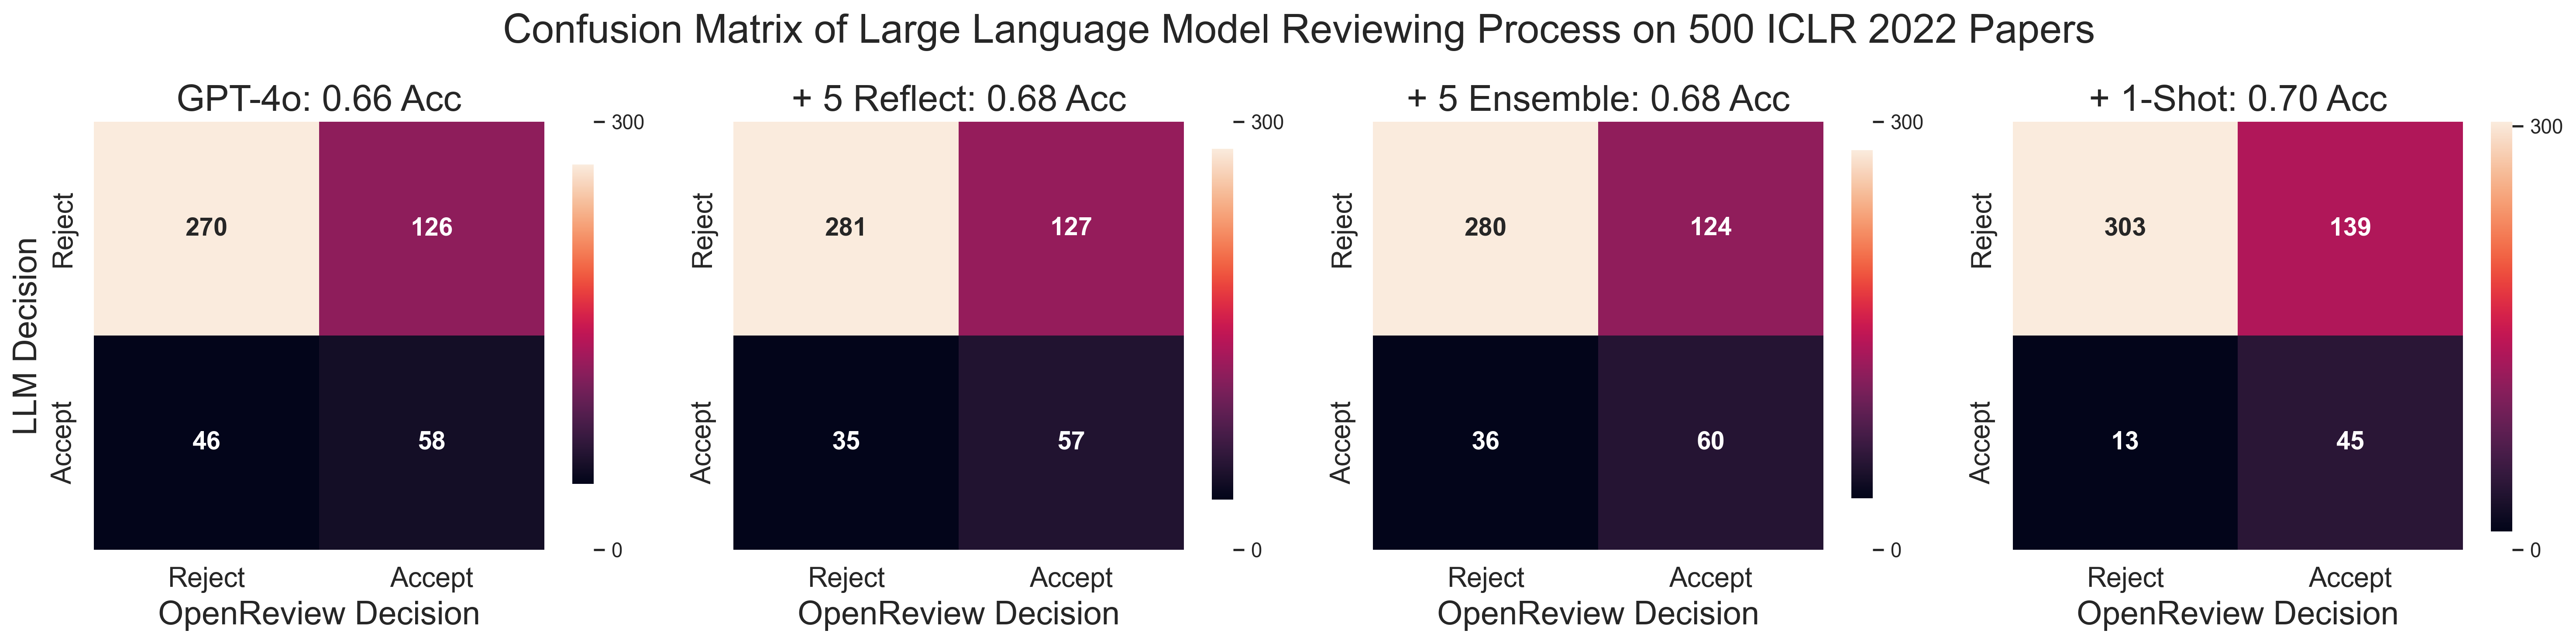

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# get_confusion_acc(gpt_4o_mini, "GPT-4o-mini", axs.flatten()[0])
get_confusion_acc(
    gpt_4o_no_fs_no_ens_no_reflect, "GPT-4o", axs.flatten()[0], plot_ylabel=True
)
get_confusion_acc(gpt_4o_no_fs_no_ens, "+ 5 Reflect", axs.flatten()[1])
get_confusion_acc(gpt_4o_no_fs, "+ 5 Ensemble", axs.flatten()[2])
get_confusion_acc(gpt_4o, "+ 1-Shot", axs.flatten()[3])
# set suptitle for figure
fig.suptitle(
    "Confusion Matrix of Large Language Model Reviewing Process on 500 ICLR 2022 Papers",
    fontsize=22,
    y=0.98,
)
fig.tight_layout()
plt.savefig("confusion_matrix.png", dpi=600)

# Correlation Human Reviewers & LLM / Average Score

In [5]:
from scipy import stats

ore_reviews = prep_open_review_data()
df = pd.read_csv(
    "llm_reviews/gpt-4o-2024-05-13_temp_0_1_fewshot_1_reflect_5_ensemble_5_pages_all.csv",
    index_col=0,
)
df["mean"] = ore_reviews["mean"]
ore_reviews.head()

,0,1,2,3,4,5,6,decision,mean,url,paper_id,simplified_decision
paper_id,,,,,,,,,,,,
1XdUvpaTNlM,5.0,5.0,3.0,6.0,NaN,NaN,NaN,Reject,4.750000,https://openreview.net/pdf?id=1XdUvpaTNlM,1XdUvpaTNlM,Reject
eIvzaLx6nKW,6.0,6.0,5.0,NaN,NaN,NaN,NaN,Reject,5.666667,https://openreview.net/pdf?id=eIvzaLx6nKW,eIvzaLx6nKW,Reject
ptZfV8tJbpe,5.0,3.0,3.0,3.0,6.0,NaN,NaN,Reject,4.000000,https://openreview.net/pdf?id=ptZfV8tJbpe,ptZfV8tJbpe,Reject
reFFte7mA0F,5.0,8.0,5.0,NaN,NaN,NaN,NaN,Reject,6.000000,https://openreview.net/pdf?id=reFFte7mA0F,reFFte7mA0F,Reject
N0uJGWDw21d,8.0,6.0,6.0,6.0,NaN,NaN,NaN,Accept (Poster),6.500000,https://openreview.net/pdf?id=N0uJGWDw21d,N0uJGWDw21d,Accept


In [6]:
# Sample random review from 0, 1, 2, 3, 4, 5, 6
np.random.seed(42)
sampled_reviews_A = []
sampled_reviews_B = []

review_cols = ["0", "1", "2", "3", "4", "5", "6"]
for pid in range(ore_reviews.shape[0]):
    # collect all reviews in cols
    reviews = []
    for col in review_cols:
        score = ore_reviews[col].iloc[pid]
        # add score if not NaN
        if not np.isnan(score):
            reviews.append(score)
    # sample two scores without replacement
    random_pair = np.random.choice(reviews, 2, replace=False)
    sampled_reviews_A.append(random_pair[0])
    sampled_reviews_B.append(random_pair[1])

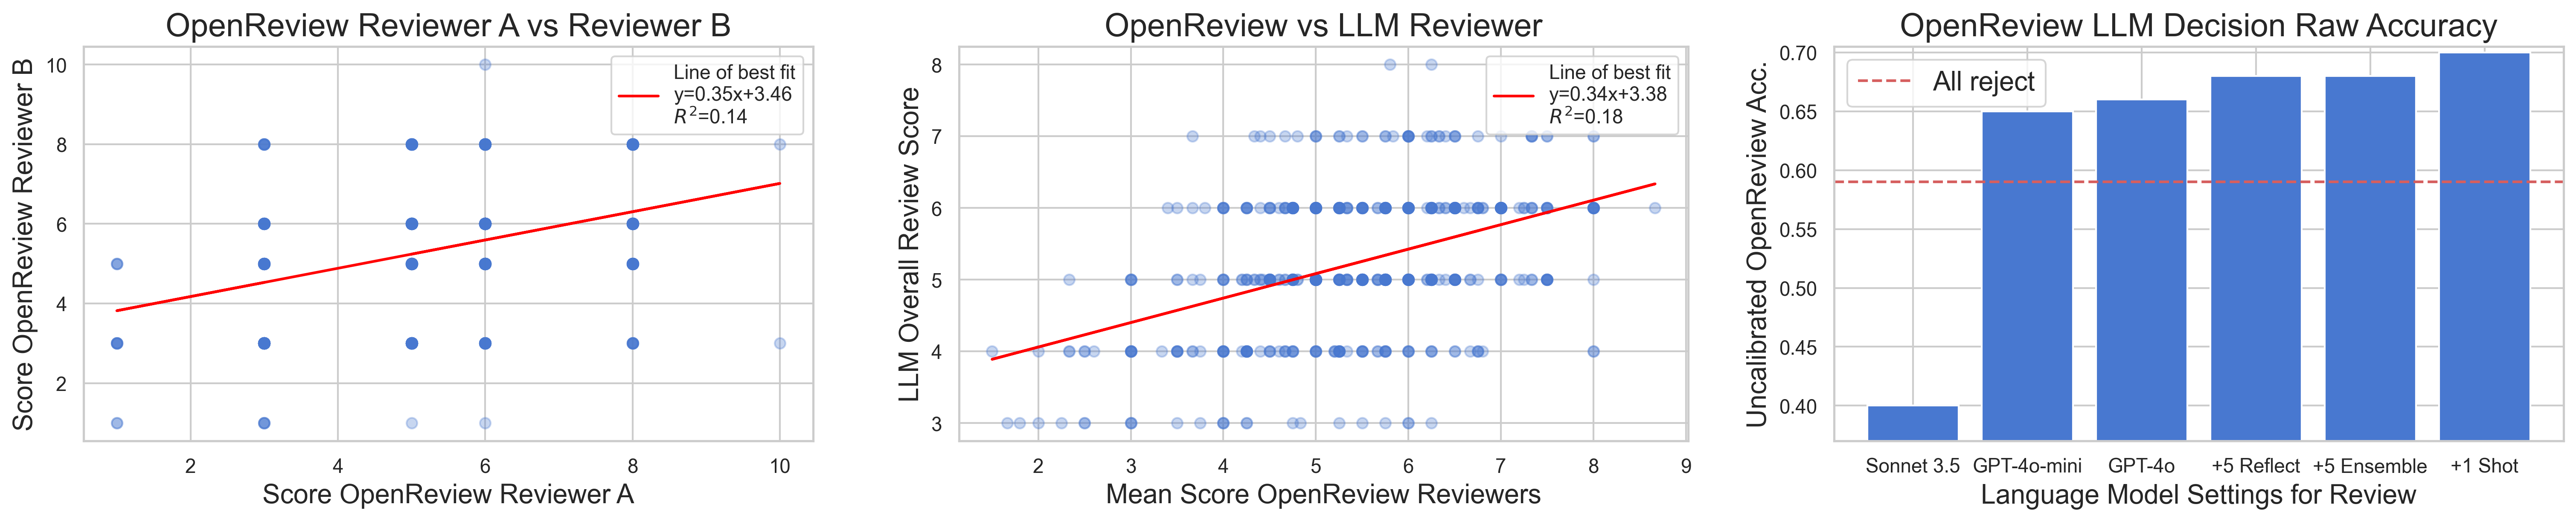

In [51]:
import seaborn as sns

sns.set_theme(style="whitegrid", palette="muted")

fig, axs = plt.subplots(1, 3, figsize=(25, 4))


def plot_reviewer_correlation(ax, reviews_0, reviews_1, xlabel, ylabel, title):
    ax.scatter(reviews_0, reviews_1, alpha=0.3)

    slope, intercept, r_value, p_value, std_err = stats.linregress(reviews_0, reviews_1)

    # Create a line based on the slope and intercept
    line = slope * np.array(reviews_0) + intercept

    # Plot the linear regression line
    ax.plot(
        reviews_0,
        line,
        color="red",
        label=f"Line of best fit\ny={slope:.2f}x+{intercept:.2f}\n$R^2$={r_value**2:.2f}",
    )

    # Add labels and legend
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.legend()
    ax.set_title(title, fontsize=18)


plot_reviewer_correlation(
    axs[0],
    sampled_reviews_A,
    sampled_reviews_B,
    "Score OpenReview Reviewer A",
    "Score OpenReview Reviewer B",
    "OpenReview Reviewer A vs Reviewer B",
)

plot_reviewer_correlation(
    axs[1],
    df["mean"],
    df["Overall"],
    "Mean Score OpenReview Reviewers",
    "LLM Overall Review Score",
    "OpenReview vs LLM Reviewer",
)

data = [
    claude_3_5_sonnet,
    gpt_4o_mini,
    gpt_4o_no_fs_no_ens_no_reflect,
    gpt_4o_no_fs_no_ens,
    gpt_4o_no_fs,
    gpt_4o,
]
labels = [
    "Sonnet 3.5",
    "GPT-4o-mini",
    "GPT-4o",
    "+5 Reflect",
    "+5 Ensemble",
    "+1 Shot",
]
perf = []
# acc, f1, auc, fpr, fnr
for d in data:
    metrics = get_perf_metrics(d, ore_reviews)
    perf.append(metrics[0])

axs[2].bar(
    labels,
    perf,
    # width=0.35
)
# rotate xticklabels
axs[2].set_ylim(0.37, 0.705)
axs[2].set_ylabel("Uncalibrated OpenReview Acc.", fontsize=15)
axs[2].set_title("OpenReview LLM Decision Raw Accuracy", fontsize=18)
axs[2].set_xlabel("Language Model Settings for Review", fontsize=15)
# horizontal line for baseline
axs[2].axhline(y=0.59, color="r", linestyle="--", label="All reject")
axs[2].legend(fontsize=15)

12 12


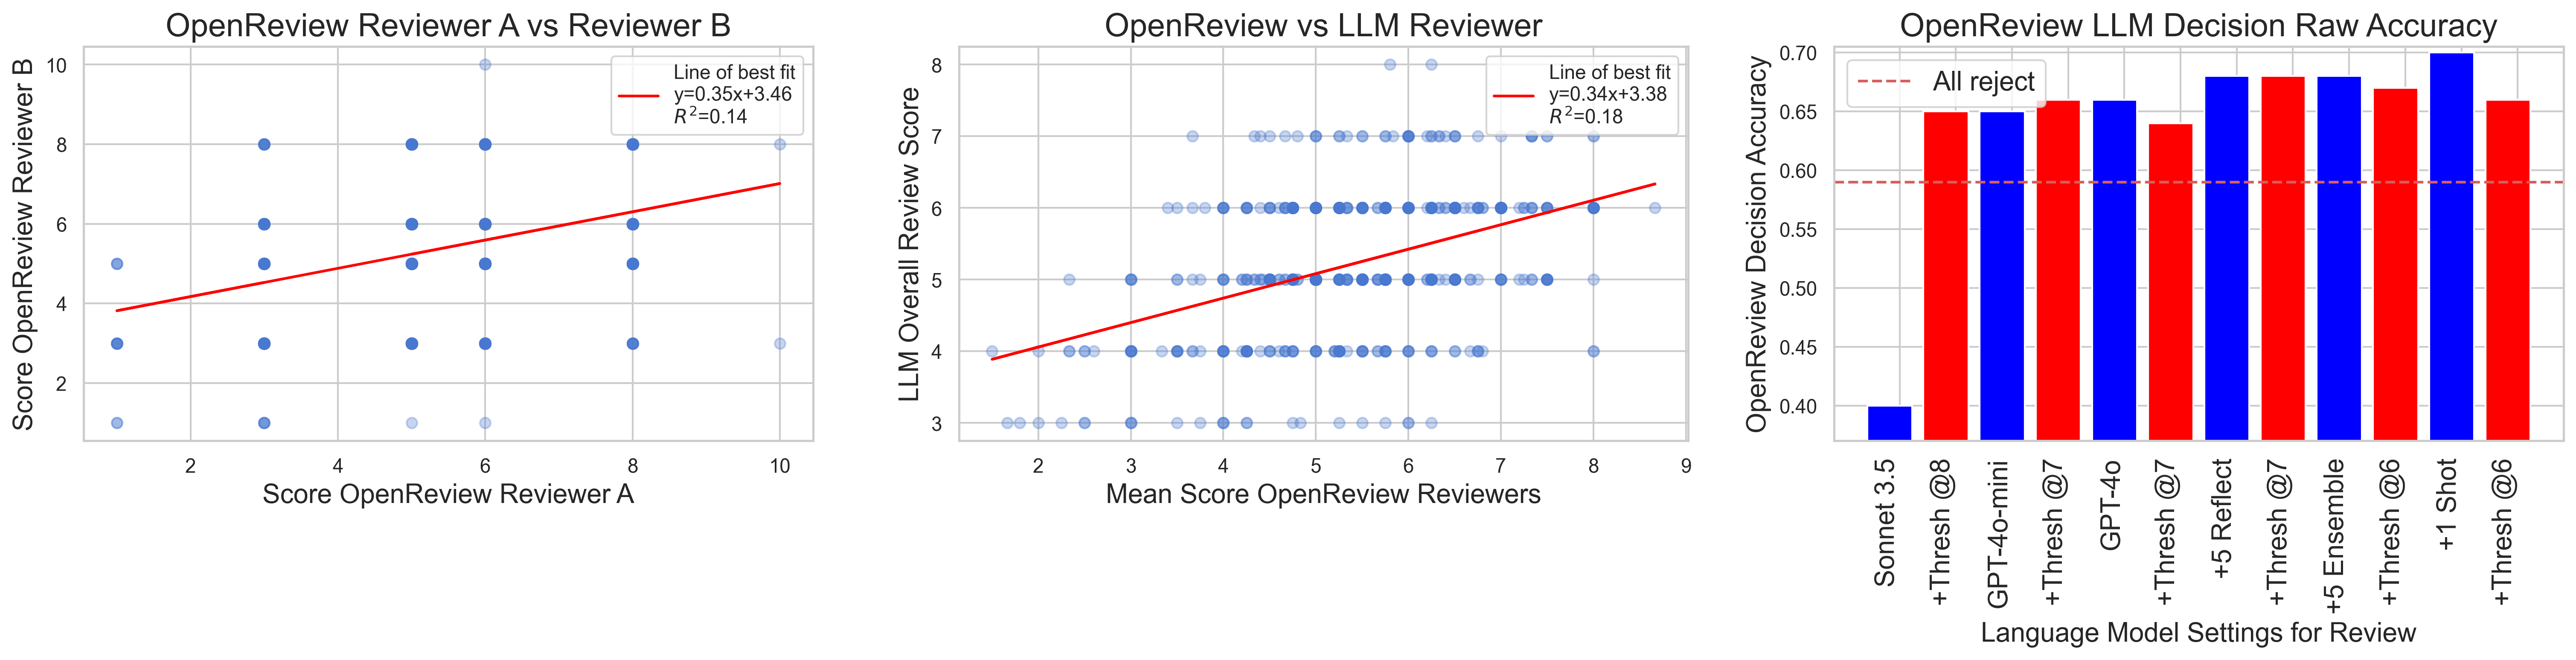

In [46]:
import seaborn as sns

sns.set_theme(style="whitegrid", palette="muted")

fig, axs = plt.subplots(1, 3, figsize=(25, 4))


def plot_reviewer_correlation(ax, reviews_0, reviews_1, xlabel, ylabel, title):
    ax.scatter(reviews_0, reviews_1, alpha=0.3)

    slope, intercept, r_value, p_value, std_err = stats.linregress(reviews_0, reviews_1)

    # Create a line based on the slope and intercept
    line = slope * np.array(reviews_0) + intercept

    # Plot the linear regression line
    ax.plot(
        reviews_0,
        line,
        color="red",
        label=f"Line of best fit\ny={slope:.2f}x+{intercept:.2f}\n$R^2$={r_value**2:.2f}",
    )

    # Add labels and legend
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.legend()
    ax.set_title(title, fontsize=18)


plot_reviewer_correlation(
    axs[0],
    sampled_reviews_A,
    sampled_reviews_B,
    "Score OpenReview Reviewer A",
    "Score OpenReview Reviewer B",
    "OpenReview Reviewer A vs Reviewer B",
)

plot_reviewer_correlation(
    axs[1],
    df["mean"],
    df["Overall"],
    "Mean Score OpenReview Reviewers",
    "LLM Overall Review Score",
    "OpenReview vs LLM Reviewer",
)

data = [
    claude_3_5_sonnet,
    gpt_4o_mini,
    gpt_4o_no_fs_no_ens_no_reflect,
    gpt_4o_no_fs_no_ens,
    gpt_4o_no_fs,
    gpt_4o,
]
labels = [
    "Sonnet 3.5",
    "GPT-4o-mini",
    "GPT-4o",
    "+5 Reflect",
    "+5 Ensemble",
    "+1 Shot",
]
perf = []
# acc, f1, auc, fpr, fnr
for d in data:
    metrics = get_perf_metrics(d, ore_reviews)
    perf.append(metrics[0])

calib_scores = [0.65, 0.66, 0.64, 0.68, 0.67, 0.66]
calib_threshs = [
    "+Thresh @8",
    "+Thresh @7",
    "+Thresh @7",
    "+Thresh @7",
    "+Thresh @6",
    "+Thresh @6",
]

labels_total = []
perf_total = []
# alternate between model and calibration
for i in range(6):
    labels_total.append(labels[i])
    labels_total.append(calib_threshs[i])
    perf_total.append(perf[i])
    perf_total.append(calib_scores[i])

print(len(labels_total), len(perf_total))

axs[2].bar(
    np.arange(12),
    perf_total,
    color=[
        "blue",
        "red",
        "blue",
        "red",
        "blue",
        "red",
        "blue",
        "red",
        "blue",
        "red",
        "blue",
        "red",
    ],
    # width=0.35
)
# rotate xticklabels
axs[2].set_xticks(np.arange(12) + 0.35 / 2)
axs[2].set_xticklabels(labels_total, rotation=90, ha="right", fontsize=15)
axs[2].set_ylim(0.37, 0.705)
axs[2].set_ylabel("OpenReview Decision Accuracy", fontsize=15)
axs[2].set_title("OpenReview LLM Decision Raw Accuracy", fontsize=18)
axs[2].set_xlabel("Language Model Settings for Review", fontsize=15)
# horizontal line for baseline
axs[2].axhline(y=0.59, color="r", linestyle="--", label="All reject")
axs[2].legend(fontsize=15)

# Accuracy Metrics Reviewer

In [8]:
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix


def get_bootstrap_metrics(llm_ratings, ore_ratings, num_bootstrap=10000):
    try:
        llm_ratings = llm_ratings.set_index("paper_id")
    except Exception:
        pass

    num_llm_reviews = llm_ratings.shape[0]
    # Get overall accuracy of decisions made by gpt
    correct = 0
    y_pred = []
    y_true = []
    for i in range(num_llm_reviews):
        name = llm_ratings.iloc[i].name
        if (
            llm_ratings["Decision"].loc[name]
            == ore_ratings["simplified_decision"].loc[name]
        ):
            correct += 1

        y_pred.append(llm_ratings["Decision"].loc[name] == "Accept")
        y_true.append(ore_ratings["simplified_decision"].loc[name] == "Accept")

    accuracy = correct / num_llm_reviews
    accuracy = round(accuracy, 2)
    f1 = round(f1_score(y_true, y_pred), 2)

    try:
        roc = round(roc_auc_score(y_true, y_pred), 2)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
    except Exception:
        roc = 0
        fpr, fnr = 0, 0

    # Extra stuff for 95% confidence
    num_accepts = tp + fn
    num_rejects = tn + fp
    accept_accuracy = tp / num_accepts if num_accepts > 0 else 0
    reject_accuracy = tn / num_rejects if num_rejects > 0 else 0
    balanced_accuracy = (accept_accuracy + reject_accuracy) / 2

    # Bootstrap for 95% CI and get all metrics
    metrics = []
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    accept_indices = np.where(y_true == 1)[0]
    reject_indices = np.where(y_true == 0)[0]

    for _ in range(num_bootstrap):
        accept_sample_indices = np.random.choice(
            accept_indices, size=len(accept_indices), replace=True
        )
        reject_sample_indices = np.random.choice(
            reject_indices, size=len(reject_indices), replace=True
        )

        sample_indices = np.concatenate([accept_sample_indices, reject_sample_indices])
        np.random.shuffle(sample_indices)

        y_pred_sample = y_pred[sample_indices]
        y_true_sample = y_true[sample_indices]

        accuracy_sample = np.mean(y_pred_sample == y_true_sample)
        f1_sample = f1_score(y_true_sample, y_pred_sample)
        try:
            roc_sample = roc_auc_score(y_true_sample, y_pred_sample)
            tn_sample, fp_sample, fn_sample, tp_sample = confusion_matrix(
                y_true_sample, y_pred_sample
            ).ravel()
            fpr_sample = fp_sample / (fp_sample + tn_sample)
            fnr_sample = fn_sample / (fn_sample + tp_sample)
        except Exception:
            roc_sample = 0
            fpr_sample, fnr_sample = 0, 0

        num_accepts_sample = tp_sample + fn_sample
        num_rejects_sample = tn_sample + fp_sample
        accept_accuracy_sample = (
            tp_sample / num_accepts_sample if num_accepts_sample > 0 else 0
        )
        reject_accuracy_sample = (
            tn_sample / num_rejects_sample if num_rejects_sample > 0 else 0
        )
        balanced_accuracy_sample = (accept_accuracy_sample + reject_accuracy_sample) / 2

        metrics.append(
            [
                accuracy_sample,
                f1_sample,
                roc_sample,
                fpr_sample,
                fnr_sample,
                accept_accuracy_sample,
                reject_accuracy_sample,
                balanced_accuracy_sample,
            ]
        )

    metrics = np.array(metrics)
    ci_lower = np.percentile(metrics, 2.5, axis=0)
    ci_upper = np.percentile(metrics, 97.5, axis=0)

    return {
        "balanced_accuracy": (balanced_accuracy, ci_lower[7], ci_upper[7]),
        "accuracy": (accuracy, ci_lower[0], ci_upper[0]),
        "f1": (f1, ci_lower[1], ci_upper[1]),
        "roc": (roc, ci_lower[2], ci_upper[2]),
        "fpr": (fpr, ci_lower[3], ci_upper[3]),
        "fnr": (fnr, ci_lower[4], ci_upper[4]),
        "accept_accuracy": (accept_accuracy, ci_lower[5], ci_upper[5]),
        "reject_accuracy": (reject_accuracy, ci_lower[6], ci_upper[6]),
    }

In [22]:
path_fnames = [
    "claude-3-5-sonnet-20240620_temp_0_1_reflect_5_ensemble_5_pages_all.csv",
    "gpt-4o-mini-2024-07-18_temp_0_1_fewshot_1_reflect_5_ensemble_5_pages_all.csv",
    "gpt-4o-2024-05-13_temp_0_1_fewshot_1_reflect_5_ensemble_5_pages_all.csv",
    "gpt-4o-2024-05-13_temp_0_1_reflect_5_ensemble_5_pages_all.csv",
    "gpt-4o-2024-05-13_temp_0_1_reflect_5_pages_all.csv",
    "gpt-4o-2024-05-13_temp_0_1_pages_all.csv",
]
for p in path_fnames:
    gpt_reviews = pd.read_csv("llm_reviews/" + p)
    bootstrap_metrics = get_bootstrap_metrics(gpt_reviews, ore_reviews)
    print(f"Model: {p}")
    for k, v in bootstrap_metrics.items():
        print(f"{k}: {v[0]:.2f} +/- {(v[2] - v[1]) / 2:.2f}")

    for thr in [5, 6, 7, 8]:
        gpt_reviews["Decision"] = gpt_reviews["Overall"].apply(
            lambda x: "Accept" if x >= thr else "Reject"
        )
        bootstrap_metrics = get_bootstrap_metrics(gpt_reviews, ore_reviews)
        print(f"Threshold {thr}:")
        for k, v in bootstrap_metrics.items():
            print(f"{k}: {v[0]:.2f} +/- {(v[2] - v[1]) / 2:.2f}")

    print()

Model: claude-3-5-sonnet-20240620_temp_0_1_reflect_5_ensemble_5_pages_all.csv
balanced_accuracy: 0.52 +/- 0.01
accuracy: 0.40 +/- 0.01
f1: 0.55 +/- 0.01
roc: 0.52 +/- 0.01
fpr: 0.95 +/- 0.02
fnr: 0.00 +/- 0.00
accept_accuracy: 1.00 +/- 0.00
reject_accuracy: 0.05 +/- 0.02
Threshold 5:
balanced_accuracy: 0.51 +/- 0.01
accuracy: 0.38 +/- 0.01
f1: 0.54 +/- 0.00
roc: 0.51 +/- 0.01
fpr: 0.98 +/- 0.01
fnr: 0.00 +/- 0.00
accept_accuracy: 1.00 +/- 0.00
reject_accuracy: 0.02 +/- 0.01
Threshold 6:
balanced_accuracy: 0.53 +/- 0.01
accuracy: 0.40 +/- 0.01
f1: 0.55 +/- 0.01
roc: 0.53 +/- 0.01
fpr: 0.95 +/- 0.02
fnr: 0.00 +/- 0.00
accept_accuracy: 1.00 +/- 0.00
reject_accuracy: 0.05 +/- 0.02
Threshold 7:
balanced_accuracy: 0.55 +/- 0.02
accuracy: 0.44 +/- 0.03
f1: 0.56 +/- 0.02
roc: 0.55 +/- 0.02
fpr: 0.86 +/- 0.04
fnr: 0.04 +/- 0.03
accept_accuracy: 0.96 +/- 0.03
reject_accuracy: 0.14 +/- 0.04
Threshold 8:
balanced_accuracy: 0.59 +/- 0.04
accuracy: 0.65 +/- 0.04
f1: 0.45 +/- 0.06
roc: 0.59 +/- 0.04


In [9]:
path_fnames = [
    "claude-3-5-sonnet-20240620_temp_0_1_reflect_5_ensemble_5_pages_all.csv",
    "gpt-4o-mini-2024-07-18_temp_0_1_fewshot_1_reflect_5_ensemble_5_pages_all.csv",
    "gpt-4o-2024-05-13_temp_0_1_fewshot_1_reflect_5_ensemble_5_pages_all.csv",
    # "gpt-4o-2024-05-13_temp_0_1_reflect_5_ensemble_5_pages_all.csv",
    # "gpt-4o-2024-05-13_temp_0_1_reflect_5_pages_all.csv",
    # "gpt-4o-2024-05-13_temp_0_1_pages_all.csv",
]
for p in path_fnames:
    gpt_reviews = pd.read_csv("llm_reviews/" + p)
    bootstrap_metrics = get_bootstrap_metrics(gpt_reviews, ore_reviews)
    print(f"Model: {p}")
    for k, v in bootstrap_metrics.items():
        print(f"{k}: {v[0]:.2f} +/- {(v[2] - v[1]) / 2:.2f}")

    for thr in [5, 6, 7, 8]:
        gpt_reviews["Decision"] = gpt_reviews["Overall"].apply(
            lambda x: "Accept" if x >= thr else "Reject"
        )
        bootstrap_metrics = get_bootstrap_metrics(gpt_reviews, ore_reviews)
        print(f"Threshold {thr}:")
        for k, v in bootstrap_metrics.items():
            print(f"{k}: {v[0]:.2f} +/- {(v[2] - v[1]) / 2:.2f}")

    print()

Model: claude-3-5-sonnet-20240620_temp_0_1_reflect_5_ensemble_5_pages_all.csv
balanced_accuracy: 0.52 +/- 0.01
accuracy: 0.40 +/- 0.01
f1: 0.55 +/- 0.01
roc: 0.52 +/- 0.01
fpr: 0.95 +/- 0.02
fnr: 0.00 +/- 0.00
accept_accuracy: 1.00 +/- 0.00
reject_accuracy: 0.05 +/- 0.02
Threshold 5:
balanced_accuracy: 0.51 +/- 0.01
accuracy: 0.38 +/- 0.01
f1: 0.54 +/- 0.00
roc: 0.51 +/- 0.01
fpr: 0.98 +/- 0.01
fnr: 0.00 +/- 0.00
accept_accuracy: 1.00 +/- 0.00
reject_accuracy: 0.02 +/- 0.01
Threshold 6:
balanced_accuracy: 0.53 +/- 0.01
accuracy: 0.40 +/- 0.01
f1: 0.55 +/- 0.01
roc: 0.53 +/- 0.01
fpr: 0.95 +/- 0.02
fnr: 0.00 +/- 0.00
accept_accuracy: 1.00 +/- 0.00
reject_accuracy: 0.05 +/- 0.02
Threshold 7:
balanced_accuracy: 0.55 +/- 0.02
accuracy: 0.44 +/- 0.03
f1: 0.56 +/- 0.02
roc: 0.55 +/- 0.02
fpr: 0.86 +/- 0.04
fnr: 0.04 +/- 0.03
accept_accuracy: 0.96 +/- 0.03
reject_accuracy: 0.14 +/- 0.04
Threshold 8:
balanced_accuracy: 0.59 +/- 0.04
accuracy: 0.65 +/- 0.04
f1: 0.45 +/- 0.06
roc: 0.59 +/- 0.04
